In [1]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertModel

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

pl.seed_everything(42)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Global seed set to 42


42

In [4]:
# Many weights are innitialized randomly, namely the cross attentio weights

from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k', 'distilgpt2')


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.4.crossattention.masked_bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.3.crossattention.bias', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.4.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.2.ln_cross_attn.weight', 'transformer.h.5.ln_cross_attn.weight', 'transformer.h.3.crossattention.c_attn.weight', 'transformer.h.0.crossattention.masked_bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.3.crossattention.c_proj.weight', 'transformer.h.5.crossattention.c_attn.weight', 'transformer.h.2.crossattention.masked_bias', 'transformer.h.2.crossattention.q_attn.weight', 'transform

In [3]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

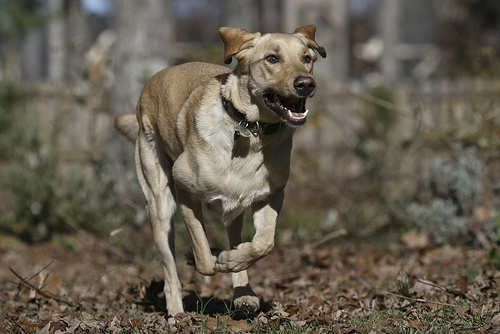

In [4]:
from PIL import Image

image = Image.open('../data/flicker_images/3148647065_2d6cd88cf6.jpg')

image

In [5]:
from numpy import asarray

image_matrix = asarray(image)
image_matrix.shape

image_matrix.shape

(334, 500, 3)

In [2]:
from transformers import GPT2Tokenizer

MIN_SEQ_LENGTH, MAX_SEQ_LENGTH = 4, 5

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', max_length=MAX_SEQ_LENGTH + 5, padding='max_length', truncation=True)

# We will add a custom new token to expand our vocabulary. 
#  This is not necessary per say but can be useful to help GPT learn a new task.

special_words_to_add={"additional_special_tokens": ['<caption>']}
gpt2_tokenizer.add_special_tokens(special_words_to_add)


1

In [7]:
gpt2_tokenizer.added_tokens_decoder

{50257: '<caption>'}

In [8]:
model.config.decoder_start_token = '<caption>'
model.config.decoder_start_token_id = 50257

In [9]:
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

In [10]:
from transformers import GPT2LMHeadModel
GPT2LMHeadModel.from_pretrained('distilgpt2')  # GPT2 with no cross attention

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [11]:
model.decoder  # GPT2 with cross attention

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D()
          (q_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace

In [12]:
model.decoder.resize_token_embeddings(len(gpt2_tokenizer))

model.config.vocab_size = model.config.decoder.vocab_size

In [13]:
model.config

VisionEncoderDecoderConfig {
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "length_penalty": 1.0,
    "max_length": 20,
    "min_length": 0,
    "model_type": "gpt2",
    "n_ctx"

In [14]:
import os
import numpy as np

IMAGES_PATH = '../data/flicker_images'

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                # We will add a start and an end token to each caption
                caption = caption.replace(' .', '').strip()
                tokens = caption.strip().split()
                
                caption = f"{model.config.decoder_start_token} {caption} {gpt2_tokenizer.eos_token}"
                
                
                if len(tokens) < MIN_SEQ_LENGTH or len(tokens) > MAX_SEQ_LENGTH:
                    continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = load_captions_data("/Users/sinanozdemir/Downloads/Flickr8k_text/Flickr8k.token.txt")


In [15]:
len(captions_mapping)

1437

In [16]:
total_captions = ([len(v) for k, v in captions_mapping.items()])
captions_mapping

{'../data/flicker_images/101654506_8eb26cfb60.jpg': ['<caption> A dog running through snow <|endoftext|>'],
 '../data/flicker_images/102351840_323e3de834.jpg': ['<caption> Two men are ice fishing <|endoftext|>'],
 '../data/flicker_images/102455176_5f8ead62d5.jpg': ['<caption> Climber climbing an ice wall <|endoftext|>'],
 '../data/flicker_images/105342180_4d4a40b47f.jpg': ['<caption> A woman with a paddle <|endoftext|>'],
 '../data/flicker_images/1055623002_8195a43714.jpg': ['<caption> Children having a pillow fight <|endoftext|>'],
 '../data/flicker_images/106490881_5a2dd9b7bd.jpg': ['<caption> Children playing on the beach <|endoftext|>'],
 '../data/flicker_images/107318069_e9f2ef32de.jpg': ['<caption> People watching hot air balloons <|endoftext|>'],
 '../data/flicker_images/1079274291_9aaf896cc1.jpg': ['<caption> Two boys make faces <|endoftext|>'],
 '../data/flicker_images/1082252566_8c79beef93.jpg': ['<caption> Three dogs of various sizes <|endoftext|>'],
 '../data/flicker_images

In [17]:
list(captions_mapping.items())[:5]

[('../data/flicker_images/101654506_8eb26cfb60.jpg',
  ['<caption> A dog running through snow <|endoftext|>']),
 ('../data/flicker_images/102351840_323e3de834.jpg',
  ['<caption> Two men are ice fishing <|endoftext|>']),
 ('../data/flicker_images/102455176_5f8ead62d5.jpg',
  ['<caption> Climber climbing an ice wall <|endoftext|>']),
 ('../data/flicker_images/105342180_4d4a40b47f.jpg',
  ['<caption> A woman with a paddle <|endoftext|>']),
 ('../data/flicker_images/1055623002_8195a43714.jpg',
  ['<caption> Children having a pillow fight <|endoftext|>'])]

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlickerCaptionDataset(Dataset):
    """Flicker Caption Dataset"""

    def __init__(self, captions_mapping, transform, tokenizer, caption_strategy='all'):
        
        self.saved_images = {}

        self.captions_mapping = captions_mapping
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.paths, self.captions = [], []
        
        for path, captions in self.captions_mapping.items():
            if caption_strategy == 'all':
                for caption in captions:
                    self.paths.append(path)
                    self.captions.append(caption)
            elif caption_strategy == 'shortest':  
                self.paths.append(path)
                self.captions.append(min(captions, key=len))
        self.tokenized_captions = self.tokenizer(self.captions, padding=True, truncation=True, return_tensors="pt")
             
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]

        image, caption = Image.open(path), self.captions[idx]
        
        input_ids = self.tokenizer(self.captions[idx])['input_ids']
        
        sample = {'pixel_values': image, 
                  'caption': caption, 
                  'labels': self.tokenized_captions['input_ids'][idx],
                  'attention_mask': self.tokenized_captions['attention_mask'][idx],
                 }
        sample["labels"] = torch.tensor([-100 if x == self.tokenizer.pad_token_id else x for x in sample["labels"]])

        sample['pixel_values'] = self.transform(sample['pixel_values'])

        return sample

In [19]:
# A standanrd pipline to preprocess our images.

from torchvision import transforms

compose = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

sample_batch = next(iter(DataLoader(FlickerCaptionDataset(captions_mapping, compose, gpt2_tokenizer), batch_size=4)))

sample_batch['pixel_values'].shape

torch.Size([4, 3, 224, 224])

In [20]:
# Our model isn't so great.. YET
generated_captions = model.generate(sample_batch['pixel_values'], output_attentions=True, use_cache=False)
generated_captions = [gpt2_tokenizer.decode(g) for g in generated_captions]


generated_captions

['<caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption>',
 '<caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption>',
 '<caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption>',
 '<caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption>']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '<caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption> <caption>')

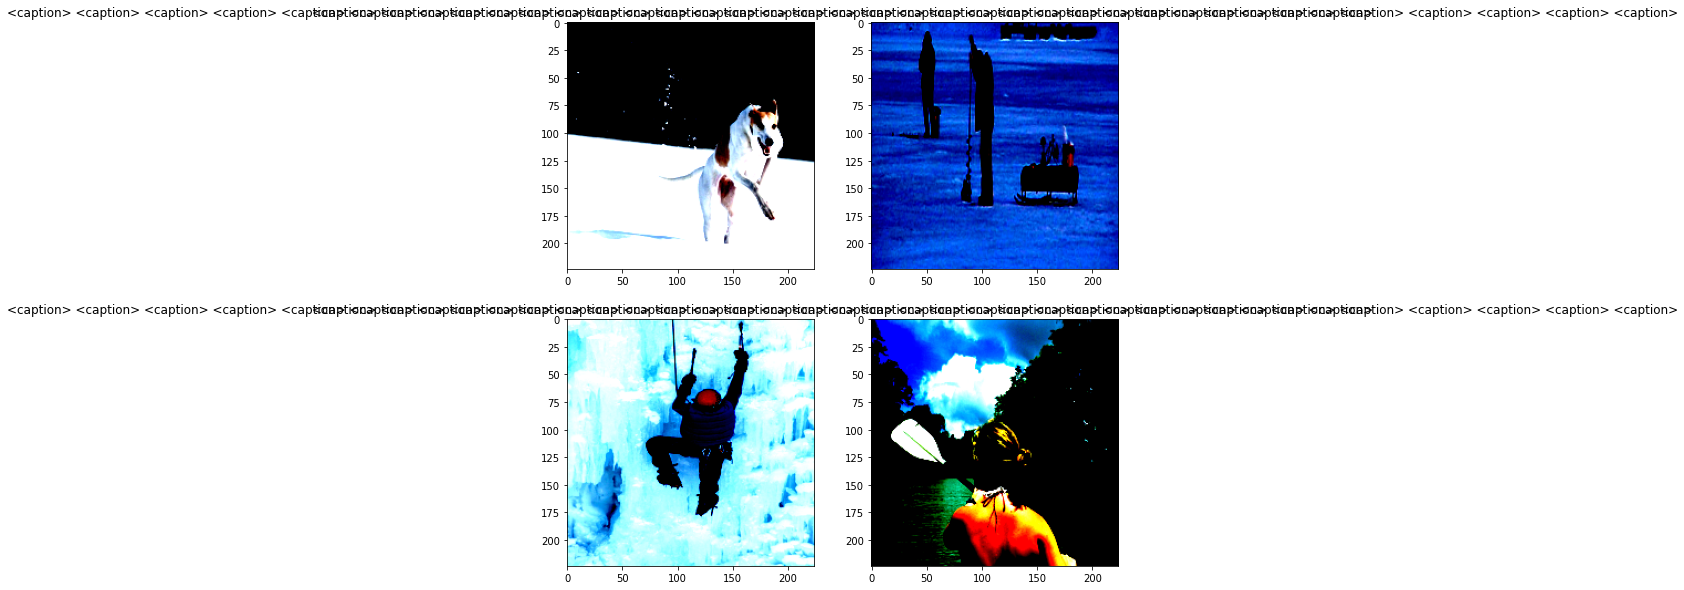

In [21]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2,2, figsize=(10, 10))
axarr[0,0].imshow(sample_batch['pixel_values'][0].numpy().transpose(1, 2, 0))
axarr[0,0].set_title(generated_captions[0])
axarr[0,1].imshow(sample_batch['pixel_values'][1].numpy().transpose(1, 2, 0))
axarr[0,1].set_title(generated_captions[1])
axarr[1,0].imshow(sample_batch['pixel_values'][2].numpy().transpose(1, 2, 0))
axarr[1,0].set_title(generated_captions[2])
axarr[1,1].imshow(sample_batch['pixel_values'][3].numpy().transpose(1, 2, 0))
axarr[1,1].set_title(generated_captions[3])

In [22]:
# We set a pad tokenn to supress a huggingface warning
model.config.pad_token_id = gpt2_tokenizer.pad_token_id


In [23]:
# Speeding up training by freezing some of the encoding layers
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.8' in name:
        break
    print("freezing", name, param.shape)
    param.requires_grad = False
    

freezing embeddings.cls_token torch.Size([1, 1, 768])
freezing embeddings.position_embeddings torch.Size([1, 197, 768])
freezing embeddings.patch_embeddings.projection.weight torch.Size([768, 3, 16, 16])
freezing embeddings.patch_embeddings.projection.bias torch.Size([768])
freezing encoder.layer.0.attention.attention.query.weight torch.Size([768, 768])
freezing encoder.layer.0.attention.attention.query.bias torch.Size([768])
freezing encoder.layer.0.attention.attention.key.weight torch.Size([768, 768])
freezing encoder.layer.0.attention.attention.key.bias torch.Size([768])
freezing encoder.layer.0.attention.attention.value.weight torch.Size([768, 768])
freezing encoder.layer.0.attention.attention.value.bias torch.Size([768])
freezing encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
freezing encoder.layer.0.attention.output.dense.bias torch.Size([768])
freezing encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
freezing encoder.layer.0.intermediate.de

In [25]:
gpt2_tokenizer(['<caption>'])

{'input_ids': [[50257]], 'attention_mask': [[1]]}

In [26]:
model.config.decoder_start_token_id

50257

In [27]:
# A HUGE loss of 50.. we hope this will go down during training
model(pixel_values=sample_batch['pixel_values'], labels=sample_batch['labels'])

Seq2SeqLMOutput(loss=tensor(50.6740, grad_fn=<NllLossBackward>), logits=tensor([[[-32.7408, -30.9148, -32.9399,  ..., -43.4310, -32.8182,  -0.5029],
         [-65.0003, -64.0548, -66.9443,  ..., -71.5839, -66.1154,  -2.5328],
         [-50.1851, -50.0513, -51.3535,  ..., -56.3588, -50.9188,  -1.8945],
         ...,
         [-51.1725, -44.2409, -46.8155,  ..., -65.1240, -53.4028,  -1.1410],
         [-50.6750, -43.7675, -46.2742,  ..., -64.7045, -52.9474,  -1.1141],
         [-50.1109, -43.2726, -45.7800,  ..., -64.2022, -52.4202,  -1.1105]],

        [[-33.1312, -31.3856, -33.3792,  ..., -43.8312, -33.1952,  -0.5264],
         [-64.0352, -63.6424, -66.5440,  ..., -70.5874, -65.2824,  -2.6163],
         [-45.9837, -46.5902, -49.6105,  ..., -53.0508, -47.9601,  -2.3035],
         ...,
         [-52.1721, -45.2312, -47.9779,  ..., -65.8236, -54.6358,  -1.2293],
         [-52.0836, -45.1157, -47.8895,  ..., -65.7135, -54.6178,  -1.2410],
         [-51.9656, -44.9851, -47.7714,  ..., -65.5

In [28]:
flicker_dataset = FlickerCaptionDataset(captions_mapping, compose, gpt2_tokenizer)

In [29]:
# 1,641 image/caption datapoints
len(flicker_dataset)

1641

In [30]:
# A 90/10 split
ninety = int(0.9 * len(flicker_dataset))

train_set, val_set = torch.utils.data.random_split(flicker_dataset, [ninety, len(flicker_dataset) - ninety])


In [31]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="image_captioning", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=7, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    load_best_model_at_end=True,
    warmup_steps=len(train_set) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    logging_steps=5,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 1476
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 470
/usr/local/lib/python3.9/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,11.749600,8.280430
2,3.693100,3.263265
3,2.914800,2.794428
4,2.752800,2.587043
5,2.512000,2.483994
6,2.100800,2.395698
7,1.841900,2.344680


***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
Saving model checkpoint to image_captioning/checkpoint-47
Configuration saved in image_captioning/checkpoint-47/config.json
Model weights saved in image_captioning/checkpoint-47/pytorch_model.bin
/usr/local/lib/python3.9/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
Saving model checkpoint to image_captioning/checkpoint-94
Configuration saved in image_captioning/checkpoint-94/config.json
Model weights saved in image_captioning/checkpoint-94/pytorch_model.bin
/usr/local/lib/python3.9/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
***** Running Evaluation *****
  Num examples = 165
  Ba

In [35]:
model.save_pretrained('image_captioning')


Configuration saved in image_captioning/config.json
Model weights saved in image_captioning/pytorch_model.bin


In [8]:
# loading model and config from pretrained folder
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./image_captioning')

# freeze model
finetuned_model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

In [303]:
import requests
from io import BytesIO

# a helper function to caption images from the web or a file path
def caption_image(m, path, n=5):
    if 'http' in path:
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = asarray(np.expand_dims(compose(img), 0))
    else:
        img = Image.open(path)
        image_matrix = asarray(np.expand_dims(compose(img), 0))

    generated = m.generate(
        torch.tensor(image_matrix),
        num_beams=n,
        min_length=3,
        max_length=10,
        no_repeat_ngram_size=2,
        temperature=1,
        top_k=20,
        early_stopping=True,
        use_cache=True,
        return_dict_in_generate=True, 
        output_attentions=True,
        num_return_sequences=n
)

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=False).strip() for g in generated.sequences]
    image_matrix  = image_matrix.squeeze(0).transpose(1, 2, 0)
    plt.imshow(image_matrix, interpolation='nearest')
    return caption_options, generated, image_matrix


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> Two people on a boat',
 '<caption> <caption> Two people on a boat iced',
 '<caption> <caption> Two people on a boat urchins',
 '<caption> <caption> Two people on a boat �',
 '<caption> <caption> Two people on a raft']

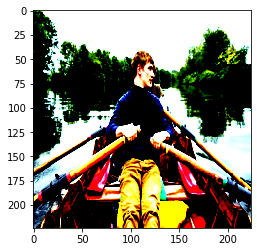

In [304]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    'https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/8/2018/07/Three-Men-in-a-Boat-James-Fisher-photo_206886102_280960501-e1532096780917.jpg'
)
captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> Two children playing in the yard �',
 '<caption> <caption> Two little girls playing in the yard',
 '<caption> <caption> Two small children playing in the forest',
 '<caption> <caption> Two children playing in the yard',
 '<caption> <caption> Two small children playing in the yard']

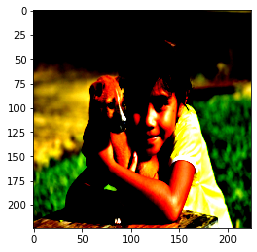

In [45]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    'https://cdn.pixabay.com/photo/2018/01/10/16/09/puppy-3074154_1280.jpg'
)
captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> A skateboarder jumps a ramp',
 '<caption> <caption> A skateboarder performs a trick',
 '<caption> <caption> A skateboarder jumps a rail',
 '<caption> <caption> a skateboarder jumps a ramp',
 '<caption> <caption> A skateboarder on a ramp']

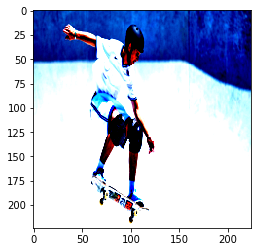

In [46]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    'https://api.time.com/wp-content/uploads/2021/08/us-skateboarding.jpg?quality=85&crop=0px%2C59px%2C1024px%2C536px&resize=1200%2C628&strip'
)
captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> Children playing on a playground �',
 '<caption> <caption> Children playing in the snow urchins',
 '<caption> <caption> Children playing in the park �',
 '<caption> <caption> Children playing in the snow �',
 '<caption> <caption> Children playing on a playground �']

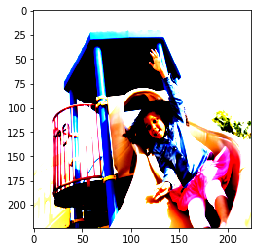

In [47]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    'https://globalnews.ca/wp-content/uploads/2018/05/playground.jpg'
)
captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> A dog running on grass __________']

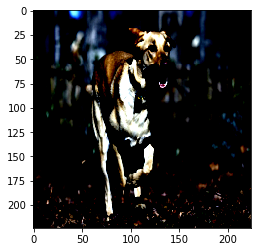

In [172]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    '../data/flicker_images/3148647065_2d6cd88cf6.jpg',
    1
)
captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<caption> <caption> A man rides a boat']

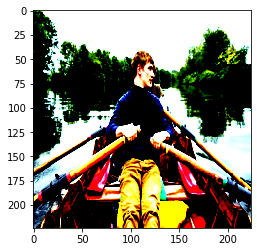

In [311]:
captions, generated, image_matrix = caption_image(
    finetuned_model, 
    'https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/8/2018/07/Three-Men-in-a-Boat-James-Fisher-photo_206886102_280960501-e1532096780917.jpg',
    1
)
captions

In [335]:
generated.cross_attentions[4][-1].shape

torch.Size([1, 12, 1, 197])

In [320]:
tokens = gpt2_tokenizer.convert_ids_to_tokens(generated.sequences[0], skip_special_tokens=False)[1:]
len(tokens), tokens

(9, ['<caption>', 'A', 'Ġman', 'Ġrides', 'Ġa', 'Ġboat', 'Ġ', 'Âł', 'Ġ'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<caption> 0 
A 1 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Ġman 2 
Ġrides 3 
Ġa 4 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Ġboat 5 
Ġ 6 
Âł 7 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Ġ 8 


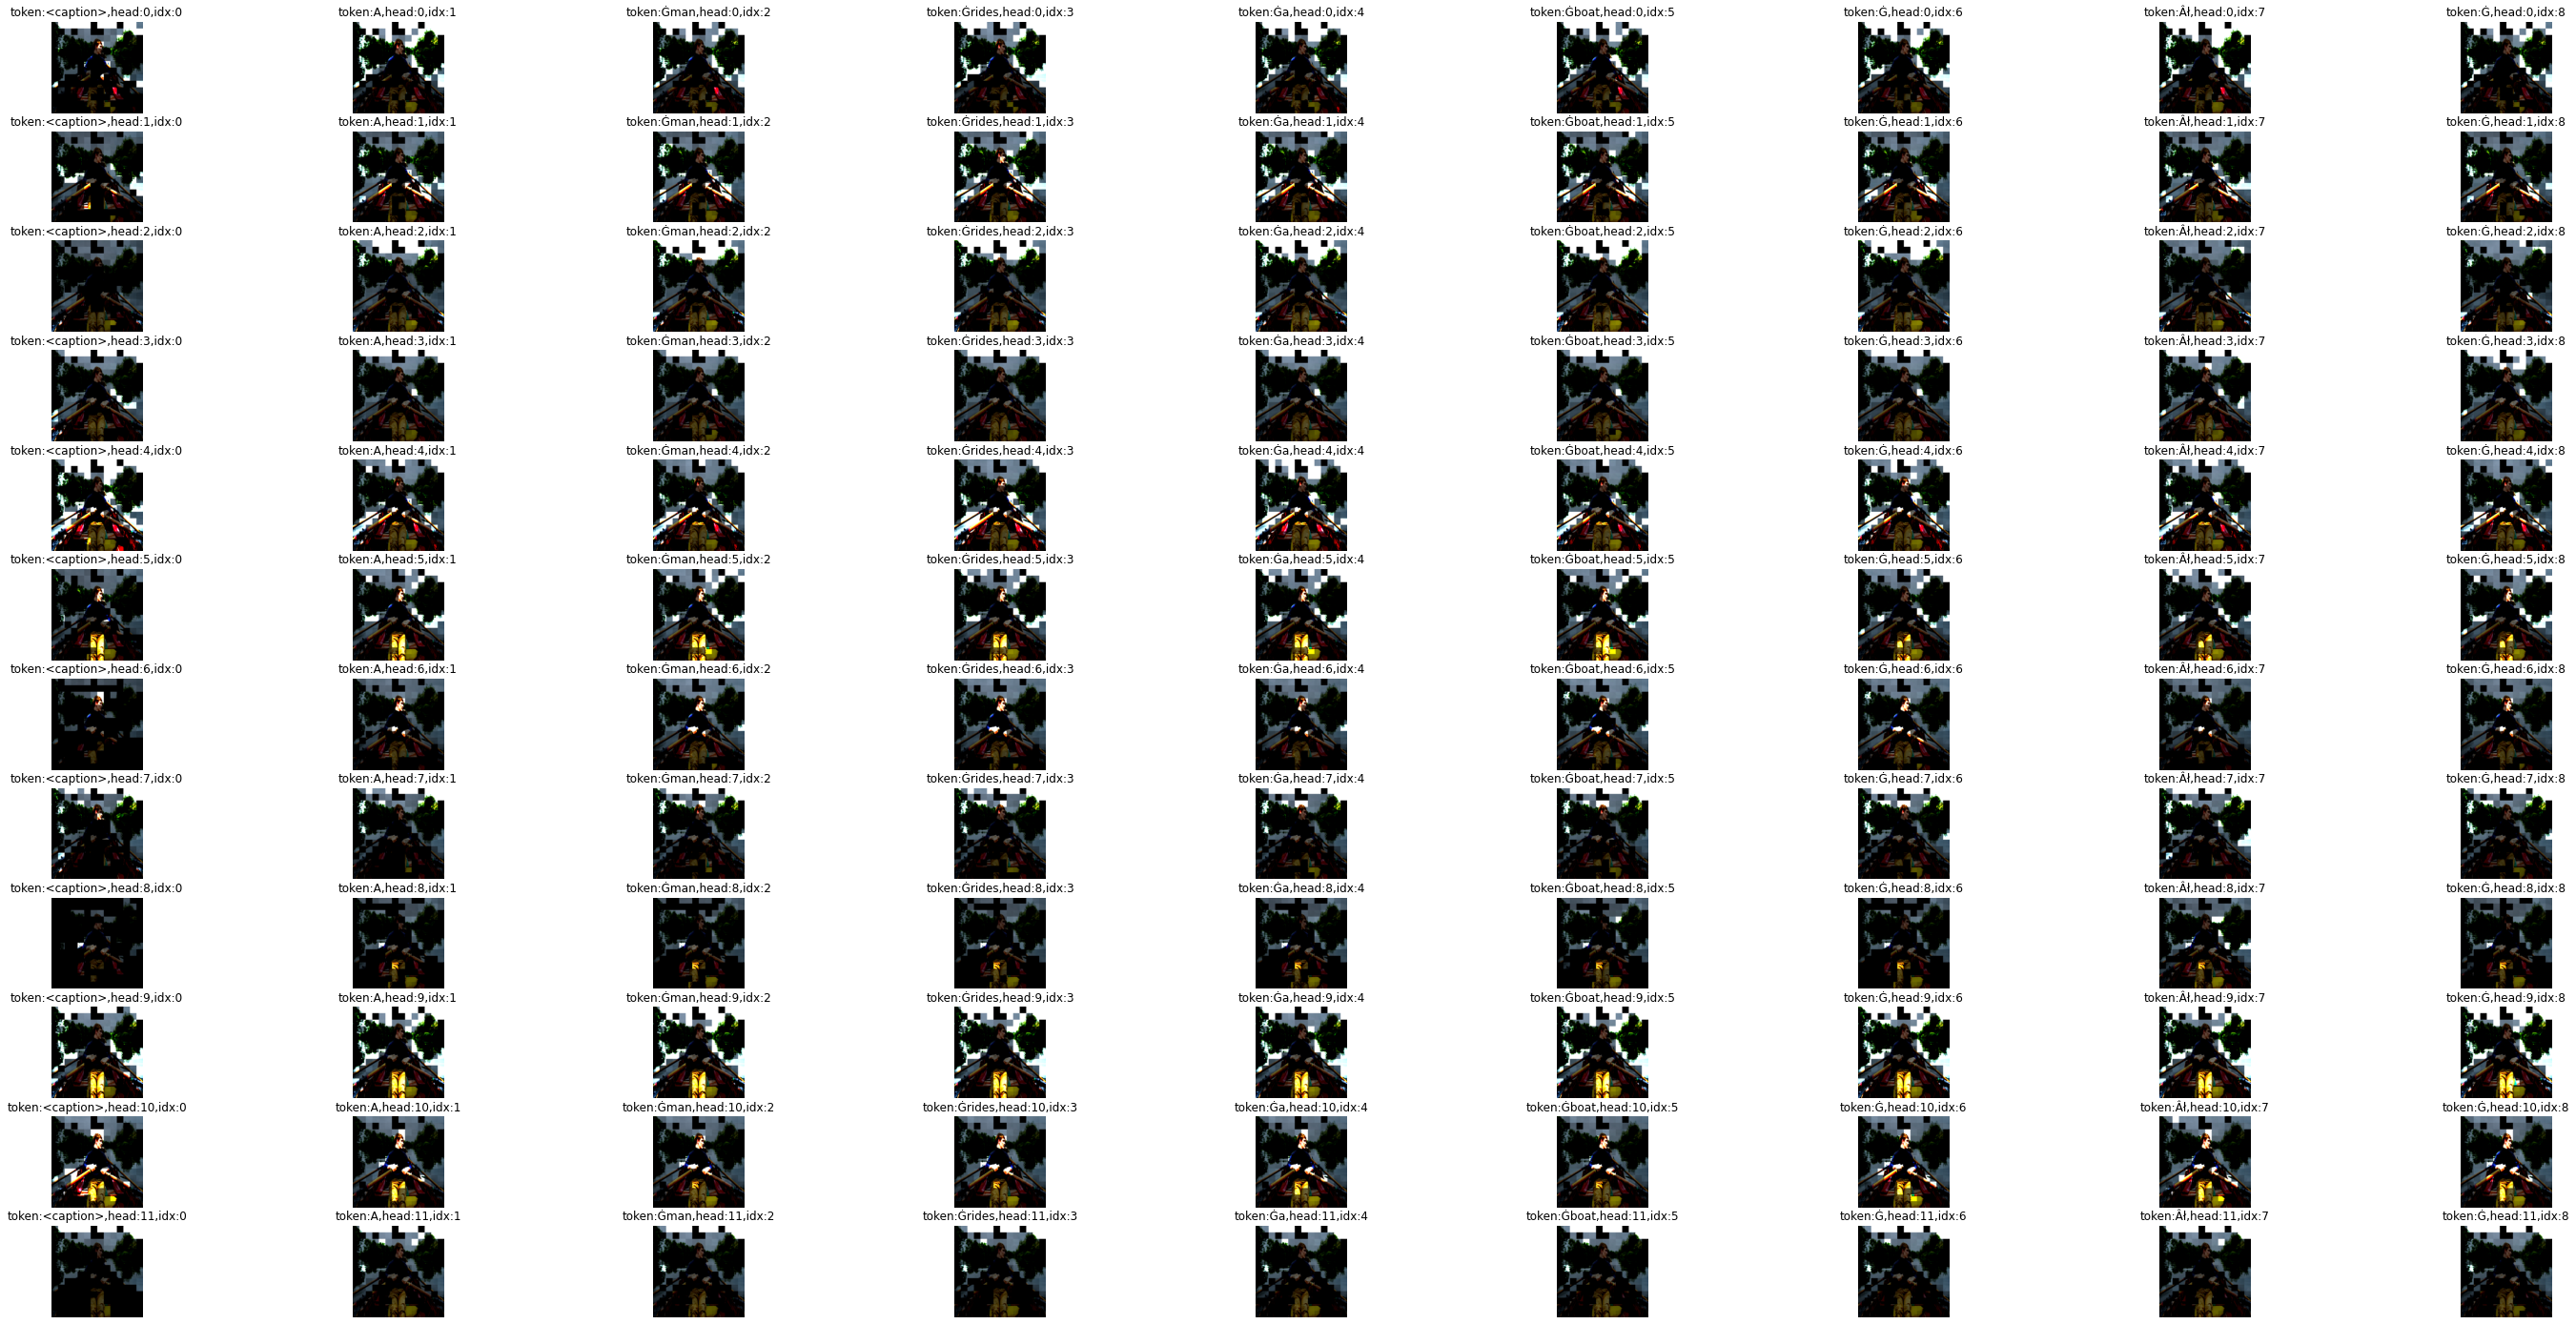

In [338]:
f, axarr = plt.subplots(12, len(tokens), figsize=(50, 25))

for idx, token in enumerate(tokens):
    print(token, idx,'\n=============')
    for head in range(12):
        attention_patch = generated.cross_attentions[idx][-1][0][head][0][1:].reshape(14, 14)
        # min-max
        attention_patch = (attention_patch - attention_patch.min()) / (attention_patch.max() -  attention_patch.min())
        # make differennces more stark
        attention_patch = np.where(attention_patch < 0.4, 0, attention_patch)
        attention_patch = np.where(attention_patch < 0.8, attention_patch / 3, attention_patch)
        attention_patch = np.where(attention_patch >= 0.8, 1, attention_patch)
        attn_image_matrix = np.copy(image_matrix)
        for x in range(14):
            for y in range(14):
                attn_image_matrix[x*16: (x*16) + 16, y*16: (y*16) + 16] *= float(attention_patch[x, y])
        axarr[head,idx].imshow(attn_image_matrix, interpolation='hamming')        
        axarr[head,idx].set_title(f'token:{token},head:{head},idx:{idx}')
        axarr[head,idx].axis('off')


In [339]:
f.savefig('../images/attention.jpg', dpi=300)

<img title="a title" alt="Attention" src="../images/attention.jpg">